In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing


from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

from nltk.stem.porter import PorterStemmer

import nltk
import string
import re

%matplotlib inline

In [2]:
# Read input Shakesphere dataset
df = pd.read_csv("Shakespeare_data.csv")

# Exploratory Data Analysis

In [3]:
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
Dataline            111396 non-null int64
Play                111396 non-null object
PlayerLinenumber    111393 non-null float64
ActSceneLine        105153 non-null object
Player              111389 non-null object
PlayerLine          111396 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


In [5]:
# Removing any null values from the dataset
# As seen from the info ActSceneLine column has a few empty values
df.isnull().sum()

Dataline               0
Play                   0
PlayerLinenumber       3
ActSceneLine        6243
Player                 7
PlayerLine             0
dtype: int64

In [6]:
#Removing rows containing null values in any of the columns 
df = df.dropna(how='any',axis=0) 

In [7]:
df.shape

(105152, 6)

The dataframe contains 105,152 instances with 6 different attributes 

In [8]:
#Getting the all the different players
num_players = df.groupby('Player').size().sort_values(ascending=False)
num_players = num_players[:50]

In [9]:
num_players.head(5)

Player
GLOUCESTER      1811
HAMLET          1503
IAGO            1101
FALSTAFF        1053
KING HENRY V    1029
dtype: int64

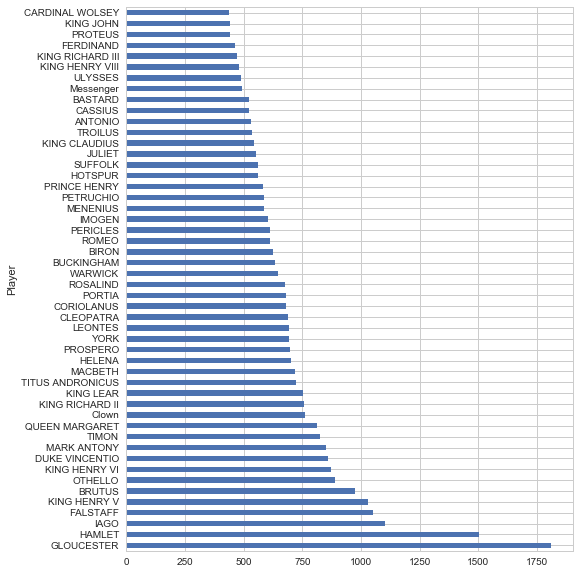

In [10]:
#Plotting distribution of player counts
num_players.plot(kind='barh',label='Top 50 Players',figsize=(8,10))

In [11]:
#Getting the all the different plays
num_plays = df.groupby('Play').size().sort_values(ascending=False)
num_plays.head()

Play
Hamlet                  4020
Coriolanus              3768
Cymbeline               3756
Richard III             3705
Antony and Cleopatra    3565
dtype: int64

Text(0.5,1,'Plays distribution')

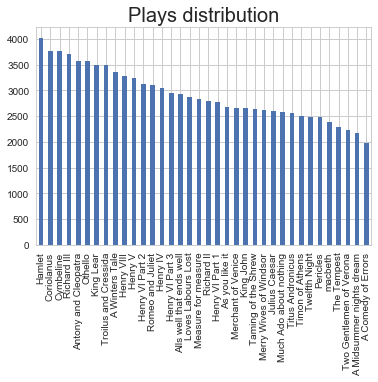

In [12]:
#Plotting plays distribution
df['Play'].value_counts().plot.bar()

plt.title("Plays distribution", fontsize=20)

The above plots shows us that the plays are fairly evenly distributed. This is good for our purpose, since the bias will not be too much when building our classifier

In [13]:
#Getting the list of all players per play 
Play_Line_Count = df.groupby(['Play','Player']).count()['PlayerLinenumber']
Play_Line_Count.head(10)

Play                Player            
A Comedy of Errors  ADRIANA               276
                    AEGEON                147
                    AEMELIA                73
                    ANGELO                 96
                    ANTIPHOLUS              6
                    BALTHAZAR              31
                    Courtezan              40
                    DROMIO OF EPHESUS     187
                    DROMIO OF SYRACUSE    314
                    DUKE SOLINUS           93
Name: PlayerLinenumber, dtype: int64

In [14]:
# Printing all different number of players in the plays
player_count = df.groupby('Player')
print("total categories:", player_count.ngroups)

('total categories:', 934)


There are a total of 934 players from all the Shakespeare's plays in our dataset. Using the initial information from our analysis, let's move on to obtain some additional features from the given features 

# Feature Engineering

In [15]:
# Performing some NLP for the PlayerLine column, such as - removing punctuations, stopwords, tokenization 

string.punctuation

#Removing punctuations from the lines
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['Player-Line'] = df['PlayerLine'].apply(lambda x: remove_punct(x))
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Player-Line
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",So shaken as we are so wan with care
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",Find we a time for frighted peace to pant
5,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils,And breathe shortwinded accents of new broils
6,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.,To be commenced in strands afar remote
7,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil,No more the thirsty entrance of this soil


In [16]:
#Tokenizing words
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['Player-Line-Tokens'] = df['Player-Line'].apply(lambda x: tokenization(x.lower()))
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Player-Line,Player-Line-Tokens
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",So shaken as we are so wan with care,"[so, shaken, as, we, are, so, wan, with, care]"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",Find we a time for frighted peace to pant,"[find, we, a, time, for, frighted, peace, to, ..."
5,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils,And breathe shortwinded accents of new broils,"[and, breathe, shortwinded, accents, of, new, ..."
6,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.,To be commenced in strands afar remote,"[to, be, commenced, in, strands, afar, remote]"
7,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil,No more the thirsty entrance of this soil,"[no, more, the, thirsty, entrance, of, this, s..."


In [17]:
#Removing stop words

stopwords = (["i","a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"])

def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text
    
df['Player-Line-Nostop'] = df['Player-Line-Tokens'].apply(lambda x: remove_stopwords(x))
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Player-Line,Player-Line-Tokens,Player-Line-Nostop
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,",So shaken as we are so wan with care,"[so, shaken, as, we, are, so, wan, with, care]","[shaken, wan, care]"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,",Find we a time for frighted peace to pant,"[find, we, a, time, for, frighted, peace, to, ...","[time, frighted, peace, pant]"
5,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils,And breathe shortwinded accents of new broils,"[and, breathe, shortwinded, accents, of, new, ...","[breathe, shortwinded, accents, new, broils]"
6,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.,To be commenced in strands afar remote,"[to, be, commenced, in, strands, afar, remote]","[commenced, strands, afar, remote]"
7,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil,No more the thirsty entrance of this soil,"[no, more, the, thirsty, entrance, of, this, s...","[thirsty, entrance, soil]"


After performing punctuation removal,tokenization, stemming and removal of stop words from the Player Line field, we now have a column with the list of keywords from each Player's line

In [18]:
#Remove redundant columns from final dataframe

#Remove Dataline column as it does not add any important information 

del df['Dataline']

#Remove PlayerLine, Player-Line and Player-Line-Tokens as the Player-Line-Nostop colum contains all the necessary information
del df['PlayerLine']
del df['Player-Line']
del df['Player-Line-Tokens']

In [19]:
df.head()

,Play,PlayerLinenumber,ActSceneLine,Player,Player-Line-Nostop
3,Henry IV,1.0,1.1.1,KING HENRY IV,"[shaken, wan, care]"
4,Henry IV,1.0,1.1.2,KING HENRY IV,"[time, frighted, peace, pant]"
5,Henry IV,1.0,1.1.3,KING HENRY IV,"[breathe, shortwinded, accents, new, broils]"
6,Henry IV,1.0,1.1.4,KING HENRY IV,"[commenced, strands, afar, remote]"
7,Henry IV,1.0,1.1.5,KING HENRY IV,"[thirsty, entrance, soil]"


In [20]:
#Function to combine a list of strings into a sentence
def join_strings_to_sentence(x):
    result = ' '.join(x)
    return result

In [21]:
#Separating the words in each document to form sentences for vectorization
df["PlayerLine"] = df["Player-Line-Nostop"].apply(join_strings_to_sentence)

In [22]:
df.head()

,Play,PlayerLinenumber,ActSceneLine,Player,Player-Line-Nostop,PlayerLine
3,Henry IV,1.0,1.1.1,KING HENRY IV,"[shaken, wan, care]",shaken wan care
4,Henry IV,1.0,1.1.2,KING HENRY IV,"[time, frighted, peace, pant]",time frighted peace pant
5,Henry IV,1.0,1.1.3,KING HENRY IV,"[breathe, shortwinded, accents, new, broils]",breathe shortwinded accents new broils
6,Henry IV,1.0,1.1.4,KING HENRY IV,"[commenced, strands, afar, remote]",commenced strands afar remote
7,Henry IV,1.0,1.1.5,KING HENRY IV,"[thirsty, entrance, soil]",thirsty entrance soil


# Label Encoding

Since most of our attributes are object/string types, we will have to convert them to numeric values, in order to build our classification model. Label Encoding is a feature provided by scikit learn, which takes cateforical values and converts them into numeric values 

In [23]:
#Applying Label Encoding to convert all the datatypes in the dataframe into numeric values

label_encoder = preprocessing.LabelEncoder()

df['Player'] = df['Player'].astype(str)
df['Play'] = df['Play'].astype(str)
df['PlayerLine'] = df['PlayerLine'].astype(str)
df['ActSceneLine'] = df['ActSceneLine'].astype(str)


label_encoder.fit(df['Player'])
label_encoder.fit(df['Play'])
label_encoder.fit(df['PlayerLine'])
label_encoder.fit(df['ActSceneLine'])

LabelEncoder()

In [24]:
#Adding new columns to the dataframe with the encoded values 
df['PlayLE'] = label_encoder.fit_transform(df['Play']) 
df['PlayerLE'] = label_encoder.fit_transform(df['Player']) 
df['LineLE'] = label_encoder.fit_transform(df['PlayerLine']) 
df['ActSceneLineLE'] = label_encoder.fit_transform(df['ActSceneLine'])

In [25]:
df.head(3)

,Play,PlayerLinenumber,ActSceneLine,Player,Player-Line-Nostop,PlayerLine,PlayLE,PlayerLE,LineLE,ActSceneLineLE
3,Henry IV,1.0,1.1.1,KING HENRY IV,"[shaken, wan, care]",shaken wan care,9,457,72018,324
4,Henry IV,1.0,1.1.2,KING HENRY IV,"[time, frighted, peace, pant]",time frighted peace pant,9,457,87330,435
5,Henry IV,1.0,1.1.3,KING HENRY IV,"[breathe, shortwinded, accents, new, broils]",breathe shortwinded accents new broils,9,457,8250,546


In [26]:
# Drop unnecessary columns
df = df.drop(['Player-Line-Nostop','Play','ActSceneLine','PlayerLine'],axis=1)

In [27]:
#Getting only the features/labels we need to build our model 

X = df[['PlayLE','LineLE','ActSceneLineLE','PlayerLinenumber']]
Y = df[['PlayerLE']]

In [28]:
#Converting the features and labels into array type
X = np.array(X)
Y = np.array(Y)

In [29]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 42)

# Random Forest Classifier 

In [30]:
classifier1 = RandomForestClassifier()

classifer1 = classifier1.fit(X_train, y_train)

/Users/sirishat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [31]:
y_pred = classifier1.predict(X_test)

y_pred

array([654, 625, 610, ..., 398, 175, 666])

In [32]:
y_test

array([[654],
       [178],
       [904],
       ..., 
       [398],
       [175],
       [666]])

In [34]:
print("Accuracy of Random Forest Classifier in predicting Player: %.2f" % accuracy_score(y_test, y_pred))

Accuracy of Random Forest Classifier in predicting Player: 0.75


As we can see from the Accuracy score above, the prediction is 75%, which is a pretty good accuracy for a classification model!